In [2]:
%pip install -q hvplot
# Install memory_profiler 
%pip install memory_profiler
%pip install imbalanced-learn

# Load memory_profiler extension
%load_ext memory_profiler

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import hvplot.pandas
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  roc_curve, auc, precision_recall_curve, average_precision_score,RocCurveDisplay
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import time

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)


### Introduction
- LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California.
- What we are trying to do is to predict the loan approval of a person based on the data we have been given
- Lets now **load** the data and **describe** it.

In [4]:
data = pd.read_csv("train_lending_club.csv")
print("Data imported successfully")
test_data = pd.read_csv("test_lending_club.csv")
print("Test data imported successfully")


Data imported successfully
Test data imported successfully


### Description of the data



In [5]:
data.describe()

,fico_range_low,total_acc,pub_rec,revol_util,annual_inc,int_rate,dti,mort_acc,loan_amnt,installment,pub_rec_bankruptcies,fico_range_high,revol_bal,id,open_acc,emp_length,loan_status,time_to_earliest_cr_line
count,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00,236846.00
mean,694.35,25.57,0.24,52.85,77379.53,12.60,18.53,1.73,14626.43,441.92,0.14,698.35,16956.26,49269391.36,11.81,5.99,0.83,526420.51
std,30.93,12.20,0.67,24.01,77290.67,4.48,9.21,2.04,8611.59,257.21,0.39,30.93,23829.01,20980382.07,5.59,4.24,0.37,241312.11
min,660.00,2.00,0.00,0.00,0.00,5.32,0.00,0.00,1000.00,14.77,0.00,664.00,0.00,56705.00,0.00,0.00,0.00,97113.60
25%,670.00,17.00,0.00,35.00,46000.00,9.17,12.05,0.00,8000.00,254.07,0.00,674.00,6127.00,33191497.25,8.00,2.00,1.00,360374.40
50%,685.00,24.00,0.00,53.00,65000.00,12.29,17.89,1.00,12450.00,378.20,0.00,689.00,11399.00,52979215.50,11.00,6.00,1.00,478483.20
75%,710.00,32.00,0.00,71.20,92000.00,15.31,24.52,3.00,20000.00,588.37,0.00,714.00,20431.00,66645529.25,15.00,11.00,1.00,647049.60
max,845.00,169.00,86.00,182.80,9573072.00,30.99,999.00,47.00,40000.00,1534.88,9.00,850.00,2560703.00,84363456.00,76.00,11.00,1.00,2240524.80


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236846 entries, 0 to 236845
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   issue_d                   236846 non-null  object 
 1   sub_grade                 236846 non-null  object 
 2   term                      236846 non-null  object 
 3   home_ownership            236846 non-null  object 
 4   fico_range_low            236846 non-null  float64
 5   total_acc                 236846 non-null  float64
 6   pub_rec                   236846 non-null  float64
 7   revol_util                236846 non-null  float64
 8   annual_inc                236846 non-null  float64
 9   int_rate                  236846 non-null  float64
 10  dti                       236846 non-null  float64
 11  purpose                   236846 non-null  object 
 12  mort_acc                  236846 non-null  float64
 13  loan_amnt                 236846 non-null  f

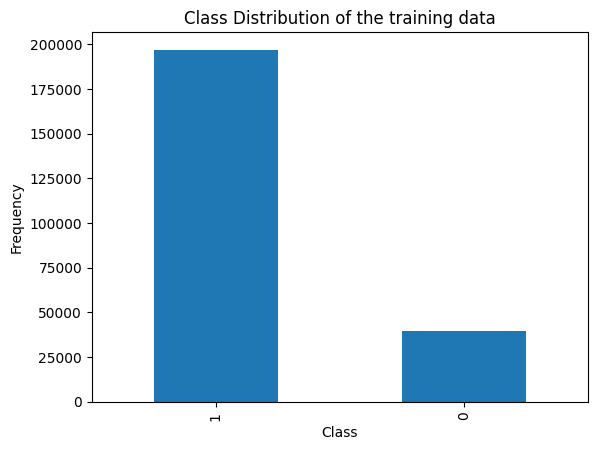

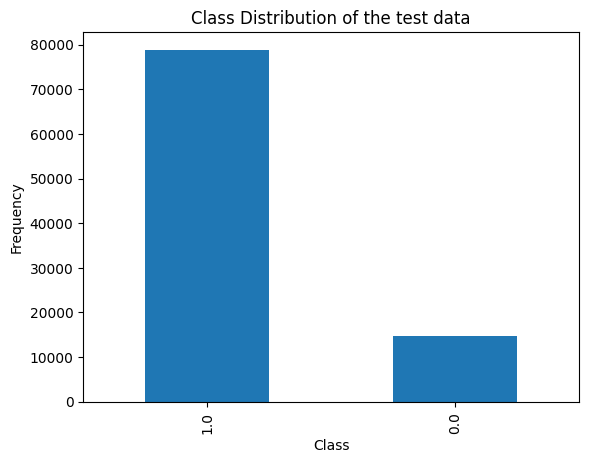

In [7]:
data['loan_status'].value_counts().plot(kind='bar')
plt.title('Class Distribution of the training data')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


test_data['loan_status'].value_counts().plot(kind='bar')
plt.title('Class Distribution of the test data')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


## Data Preprocessing
- Remove or fill any missing data
- scaling
- convert categorical data into numeric 

In [8]:
print(f"The Length of the data: {data.shape}")

The Length of the data: (236846, 27)


In [9]:
for dataset in [data, test_data]:
    for column in dataset.columns:
        if dataset[column].isna().sum() != 0:
            missing = dataset[column].isna().sum()
            portion = (missing / dataset.shape[0]) * 100
            print(f"'{column}' in {'training' if dataset is data else 'test'} dataset: number of missing values '{missing}' ==> '{portion:.3f}%'")

'home_ownership' in test dataset: number of missing values '826' ==> '0.869%'
'loan_status' in test dataset: number of missing values '1412' ==> '1.486%'


In [10]:
# Since only the test set contains missing values, we will fill the missing values 
# Separate numerical and categorical columns
numerical_cols = test_data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = test_data.select_dtypes(include=['object', 'category']).columns

# Impute numerical columns with the median
num_imputer = SimpleImputer(strategy='median')
test_data[numerical_cols] = num_imputer.fit_transform(test_data[numerical_cols])

# Impute categorical columns with the most frequent value (mode)
cat_imputer = SimpleImputer(strategy='most_frequent')
test_data[categorical_cols] = cat_imputer.fit_transform(test_data[categorical_cols])

# Check if there are any missing values left
print(test_data.isna().sum())

issue_d                     0
sub_grade                   0
term                        0
home_ownership              0
fico_range_low              0
total_acc                   0
pub_rec                     0
revol_util                  0
annual_inc                  0
int_rate                    0
dti                         0
purpose                     0
mort_acc                    0
loan_amnt                   0
application_type            0
installment                 0
verification_status         0
pub_rec_bankruptcies        0
addr_state                  0
initial_list_status         0
fico_range_high             0
revol_bal                   0
id                          0
open_acc                    0
emp_length                  0
loan_status                 0
time_to_earliest_cr_line    0
dtype: int64


### Label Encoding
- Turning Categorical values into numerical 

In [11]:
# List of categorical columns to convert
categorical_columns = ['sub_grade', 'term', 'home_ownership', 'purpose', 'application_type', 'verification_status', 'initial_list_status']

# One-hot encode these columns
data = pd.get_dummies(data, columns=categorical_columns,drop_first=True)
test_data = pd.get_dummies(test_data, columns=categorical_columns, drop_first=True)

# Ensure that both dataframes have the same dummy columns
data, test_data = data.align(test_data, join='left', axis=1, fill_value=0)

print(f"Length of the training data: {data.shape}")
print(f"Length of the test data: {test_data.shape}")

Length of the training data: (236846, 74)
Length of the test data: (95019, 74)


In [12]:
# remove issue date because before hand we don't know when the loan will be issued
# drop loan_status because it is the target
# drop id,addr_state because it is not useful

# Store 'loan_status' in a separate variable and then drop non-feature columns from the training data
y_train = data['loan_status']
X_train = data.drop(['issue_d', 'loan_status', 'id', 'addr_state'], axis=1)

y_test = test_data['loan_status']
X_test = test_data.drop(['issue_d', 'loan_status', 'id', 'addr_state'], axis=1)

print(f"Length of the training features: {X_train.shape}")
print(f"Length of the test features: {X_test.shape}")



Length of the training features: (236846, 70)
Length of the test features: (95019, 70)


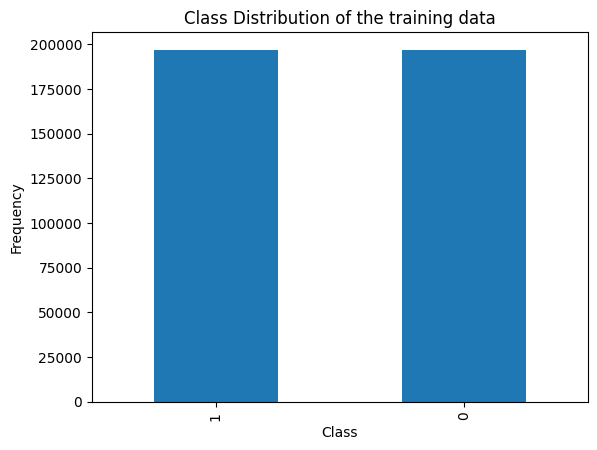

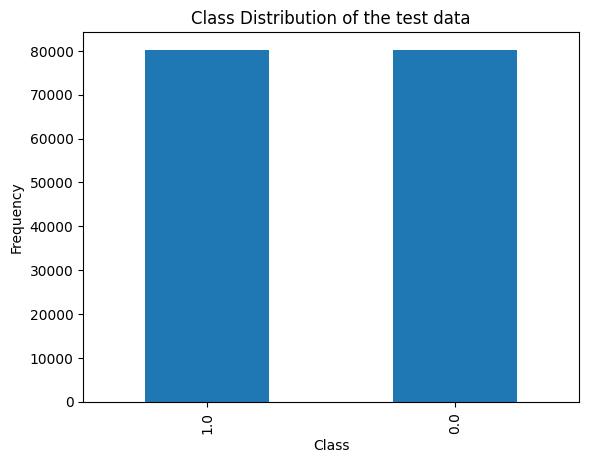

In [13]:
smote = SMOTE(sampling_strategy='minority', random_state=42)  
# Fit SMOTE on Training Data
X_train, y_train= smote.fit_resample(X_train, y_train)
# Fit SMOTE on Testing Data
X_test, y_test = smote.fit_resample(X_test, y_test)

y_train.value_counts().plot(kind='bar')
plt.title('Class Distribution of the training data')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


y_test.value_counts().plot(kind='bar')
plt.title('Class Distribution of the test data')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

### Logistic Regression


In [14]:
# Scale the numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [15]:
logistic_classifier = LogisticRegression(max_iter=1000) # You can adjust regularization parameters if needed
logistic_classifier.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

### KNN CLASSIFIER

In [16]:
# Train KNN Classifier
# in terminal set LOKY_MAX_CPU_COUNT= <number of cores you want to use>

knn_classifier = KNeighborsClassifier(n_neighbors=5) # You can adjust the number of neighbors (k) as needed
knn_classifier.fit(X_train_scaled, y_train)


KNeighborsClassifier()

### Performance evaluation Milestone 1

In [17]:
# F1 Score for Logistic Regression
logistic_f1_scores = cross_val_score(logistic_classifier, X_train_scaled, y_train, cv=5, scoring='f1')
print("Logistic Regression CV F1 Score:", logistic_f1_scores.mean())

# AUC for Logistic Regression
logistic_auc_scores = cross_val_score(logistic_classifier, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print("Logistic Regression CV ROC_AUC:", logistic_auc_scores.mean())

# Repeat for KNN
knn_f1_scores = cross_val_score(knn_classifier, X_train_scaled, y_train, cv=5, scoring='f1')
print("KNN CV F1 Score:", knn_f1_scores.mean())

knn_auc_scores = cross_val_score(knn_classifier, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print("KNN CV ROC_AUC:", knn_auc_scores.mean())


Logistic Regression CV F1 Score: 0.9016439974653864
Logistic Regression CV ROC_AUC: 0.9456449222541299
KNN CV F1 Score: 0.8864612720337076
KNN CV ROC_AUC: 0.9139352938767518


In [18]:
def plot_cv_roc_curve(classifier, X, y, cv_splits=5, classifier_name='Classifier'):
    """
    Plots ROC curves for each fold in cross-validation and the mean ROC curve.
    
    Parameters:
    - classifier: The classifier to use.
    - X: Feature set.
    - y: Target variable.
    - cv_splits: Number of cross-validation splits.
    - classifier_name: Name of the classifier (for legend labeling).
    """
    cv = StratifiedKFold(n_splits=cv_splits)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        probas_ = classifier.predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} {classifier_name} (AUC = {roc_auc:.2f})')
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=f'Mean {classifier_name} (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', lw=2, alpha=.8)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=f"Receiver Operating Characteristic - {classifier_name}")
    ax.legend(loc="lower right")
    plt.show()


In [19]:
# Measure CPU time for training KNN Classifier
start_time = time.time()
knn_classifier.fit(X_train_scaled, y_train)
end_time = time.time()
print("Time taken for training KNN Classifier:", end_time - start_time, "seconds")

# Measure memory usage for training KNN Classifier
%memit knn_classifier.fit(X_train_scaled, y_train)


# Measure CPU time for training Logistic Regression Classifier
start_time = time.time()
logistic_classifier.fit(X_train_scaled, y_train)
end_time = time.time()
print("Time taken for training Logistic Classifier:", end_time - start_time, "seconds")

# Measure memory usage for training KNN Classifier
%memit logistic_classifier.fit(X_train_scaled, y_train)

Time taken for training KNN Classifier: 0.10260748863220215 seconds
peak memory: 918.59 MiB, increment: 0.05 MiB
Time taken for training Logistic Classifier: 1.5181312561035156 seconds
peak memory: 1140.83 MiB, increment: 222.41 MiB


### Linear Discriminant Analysis AND Desicion Trees

In [20]:
# Define the LDA model
lda_model = LinearDiscriminantAnalysis()
# Measure training time for LDA
start_time = time.time()
lda_model.fit(X_train_scaled, y_train)
lda_training_time = time.time() - start_time

print(f"LDA Training Time: {lda_training_time} seconds")

# Define the Decision Tree model
dt_model = DecisionTreeClassifier()

# Measure training time for Decision Trees
start_time = time.time()
dt_model.fit(X_train_scaled, y_train)
dt_training_time = time.time() - start_time

print(f"Decision Tree Training Time: {dt_training_time} seconds")



LDA Training Time: 3.5885045528411865 seconds
Decision Tree Training Time: 13.167469263076782 seconds


### Performance and Resource Utilization

In [21]:

# AUC and F1 for LDA
lda_auc = cross_val_score(lda_model, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()
lda_f1 = cross_val_score(lda_model, X_train_scaled, y_train, cv=5, scoring='f1').mean()

print(f"LDA Mean AUC: {lda_auc}")
print(f"LDA Mean F1: {lda_f1}")

# AUC and F1 for Decision Trees
dt_auc = cross_val_score(dt_model, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()
dt_f1 = cross_val_score(dt_model, X_train_scaled, y_train, cv=5, scoring='f1').mean()

print(f"Decision Tree Mean AUC: {dt_auc}")
print(f"Decision Tree Mean F1: {dt_f1}")

LDA Mean AUC: 0.9332209865103996
LDA Mean F1: 0.9125121922945558
Decision Tree Mean AUC: 0.7744150596827354
Decision Tree Mean F1: 0.7840375897888544


In [22]:
# memeory usage for LDA
%memit lda_model.fit(X_train_scaled, y_train)
# memeory usage for Decision Trees
%memit dt_model.fit(X_train_scaled, y_train)

peak memory: 1922.61 MiB, increment: 946.69 MiB
peak memory: 1095.03 MiB, increment: 119.11 MiB


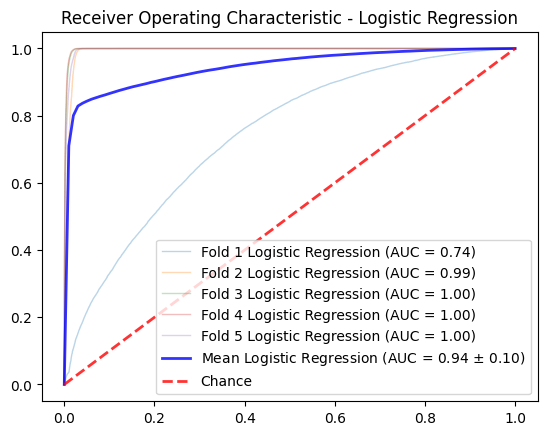

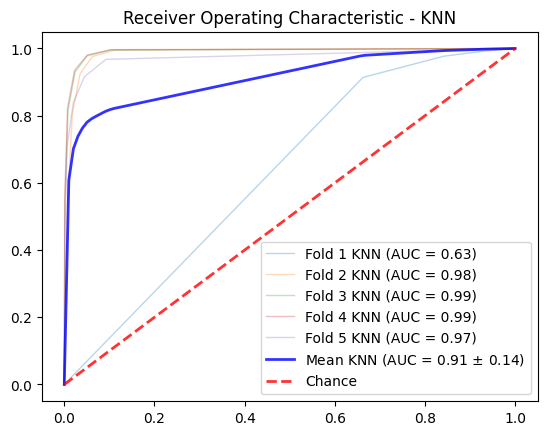

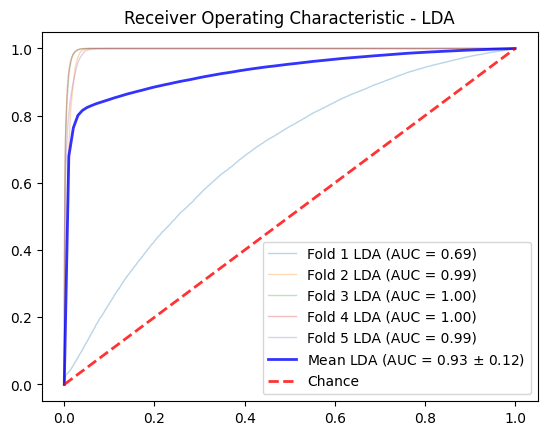

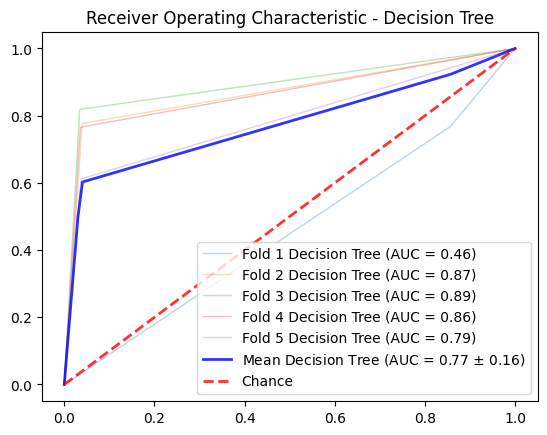

In [23]:
# For Logistic Regression
plot_cv_roc_curve(logistic_classifier, X_train_scaled, y_train, classifier_name='Logistic Regression')

# For KNN
plot_cv_roc_curve(knn_classifier, X_train_scaled, y_train, classifier_name='KNN')

# For LDA
plot_cv_roc_curve(lda_model, X_train_scaled, y_train, classifier_name='LDA')

# For Decision Trees
plot_cv_roc_curve(dt_model, X_train_scaled, y_train, classifier_name='Decision Tree')


### Precision Recall Curve

In [24]:
def plot_cv_precision_recall_curve(classifier, X, y, cv_splits=5, classifier_name='Classifier'):
    """
    Plots Precision-Recall curves for each fold in cross-validation and the mean Precision-Recall curve.
    
    Parameters:
    - classifier: The classifier to use.
    - X: Feature set.
    - y: Target variable.
    - cv_splits: Number of cross-validation splits.
    - classifier_name: Name of the classifier (for legend labeling).
    """
    cv = StratifiedKFold(n_splits=cv_splits)
    mean_recall = np.linspace(0, 1, 100)
    precisions = []
    aucs = []
    fig, ax = plt.subplots()
    
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        probas_ = classifier.predict_proba(X[test])
        precision, recall, thresholds = precision_recall_curve(y[test], probas_[:, 1])
        rev_recall = recall[::-1]  # Reverse the recall array
        rev_precision = precision[::-1]  # Reverse the precision array
        precisions.append(np.interp(mean_recall, rev_recall, rev_precision))
        precisions[-1][0] = 1.0
        pr_auc = auc(rev_recall, rev_precision)
        aucs.append(pr_auc)
        ax.plot(recall, precision, lw=1, alpha=0.3, label=f'Fold {i+1} {classifier_name} (AUC = {pr_auc:.2f})')
    
    mean_precision = np.mean(precisions, axis=0)
    mean_auc = auc(mean_recall, mean_precision)
    std_auc = np.std(aucs)
    ax.plot(mean_recall, mean_precision, color='b', label=f'Mean {classifier_name} (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', lw=2, alpha=.8)
    ax.set(xlim=[0, 1.05], ylim=[0, 1.05], title=f"Precision-Recall Curve - {classifier_name}")
    ax.legend(loc="lower left")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()


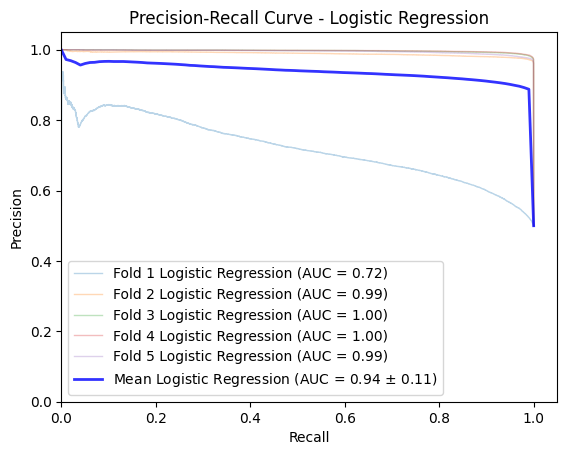

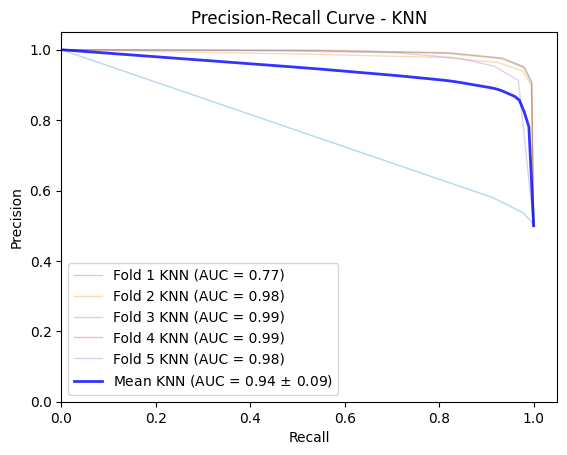

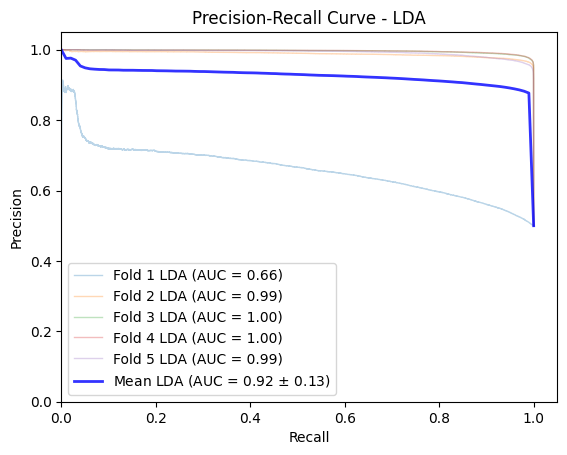

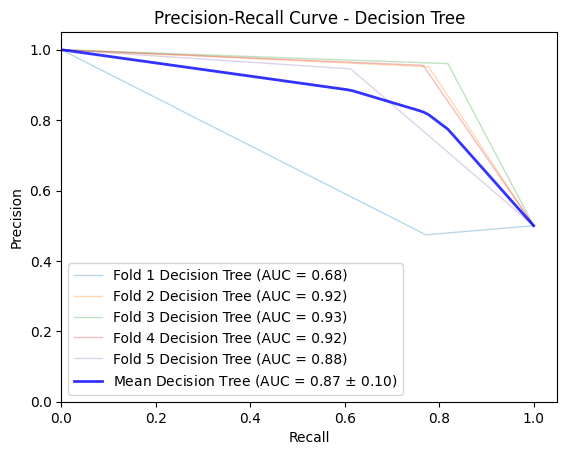

In [25]:
# For Logistic Regression
plot_cv_precision_recall_curve(logistic_classifier, X_train_scaled, y_train, classifier_name='Logistic Regression')

# For KNN
plot_cv_precision_recall_curve(knn_classifier, X_train_scaled, y_train, classifier_name='KNN')

# For LDA
plot_cv_precision_recall_curve(lda_model, X_train_scaled, y_train, classifier_name='LDA')

# For Decision Trees
plot_cv_precision_recall_curve(dt_model, X_train_scaled, y_train, classifier_name='Decision Tree')

In [26]:
# Assuming `X_test` and `y_test` are your existing test features and labels
# Split the test set into a smaller test set and a validation set
X_test_smaller, X_validation, y_test_smaller, y_validation = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

In [27]:
from memory_profiler import memory_usage

def evaluate_model(model, X_train, y_train, X_test, y_test, scaler=None):
    model_name = type(model).__name__
    print(f"Evaluating model: {model_name}")

    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Training the model
    model.fit(X_train, y_train)

    # Making predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)

    # Printing the classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Calculating ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc}")

    # Memory and time usage (optional)
    start_time = time.time()
    mem_usage_before = memory_usage(-1, interval=0.01, timeout=1, max_usage=True)
    
    # You can add any additional evaluation here if necessary
    
    mem_usage_after = memory_usage(-1, interval=0.01, timeout=1, max_usage=True)
    end_time = time.time()

    print(f"Time taken: {end_time - start_time} seconds")
    print(f"Memory usage: {mem_usage_after - mem_usage_before} MB")


evaluate_model(logistic_classifier, X_train, y_train, X_validation, y_validation)
evaluate_model(knn_classifier, X_train, y_train, X_validation, y_validation)
evaluate_model(lda_model, X_train, y_train, X_validation, y_validation)
evaluate_model(dt_model, X_train, y_train, X_validation, y_validation)

 

Evaluating model: LogisticRegression


c:\Users\Fahad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.81      0.77     40277
         1.0       0.79      0.72      0.75     39994

    accuracy                           0.76     80271
   macro avg       0.76      0.76      0.76     80271
weighted avg       0.76      0.76      0.76     80271

ROC AUC: 0.8344837121700044
Time taken: 2.1284303665161133 seconds
Memory usage: 0.0 MB
Evaluating model: KNeighborsClassifier
Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.45      0.50     40277
         1.0       0.54      0.66      0.60     39994

    accuracy                           0.56     80271
   macro avg       0.56      0.56      0.55     80271
weighted avg       0.56      0.56      0.55     80271

ROC AUC: 0.5780178206188187
Time taken: 2.3038618564605713 seconds
Memory usage: 0.0 MB
Evaluating model: LinearDiscriminantAnalysis
Classification Report:
              pre

## Feature Engineering
### Investigating Features used in the models

- Here is the table summarizing the performance and resource utilization of the models on the **training dataset**:

| Model                | Precision-Recall AUC | ROC AUC | F1 Score | Training Time (seconds) | Peak Memory (MiB) | Memory Increment (MiB) |
|----------------------|----------------------|---------|----------|-------------------------|-------------------|------------------------|
| LDA                  | 0.94                 | 0.776   | 0.901    | 2.781                   | 1236.81           | 732.88                 |
| Decision Tree        | 0.91                 | 0.552   | 0.810    | 16.527                  | 583.27            | 76.55                  |
| Logistic Regression  | 0.94                 | 0.779   | 0.903    | 1.023                   | 824.35            | 147.03                 |
| KNN                  | 0.93                 | 0.694   | 0.895    | 0.094                   | 820.09            | 142.79                 |



- The *Validation Set* gives 

| Model                        | Precision (0) | Precision (1) | Recall (0) | Recall (1) | F1-Score (0) | F1-Score (1) | Accuracy | ROC AUC | Time (seconds) | Memory Usage (MB) |
|------------------------------|---------------|---------------|------------|------------|--------------|--------------|----------|---------|----------------|-------------------|
| LogisticRegression           | 0.74          | 0.79          | 0.81       | 0.72       | 0.77         | 0.75         | 0.76     | 0.8345  | 2.231          | 0.0               |
| KNeighborsClassifier         | 0.57          | 0.54          | 0.45       | 0.66       | 0.50         | 0.60         | 0.56     | 0.5780  | 2.226          | 0.0               |
| LinearDiscriminantAnalysis   | 0.99          | 0.83          | 0.80       | 1.00       | 0.89         | 0.91         | 0.90     | 0.9627  | 2.272          | 0.0               |
| DecisionTreeClassifier       | 0.78          | 0.84          | 0.85       | 0.76       | 0.82         | 0.80         | 0.81     | 0.8075  | 2.246          | 0.0               |

Lets do Feature Engineering to increase accuracy

In [28]:
# Convert boolean columns to integers
X_train_numeric = X_train.astype(float)
X_test_numeric = X_test.astype(float)


- Notice there are a large number of columns. That is due to One-hot encoding of Categorical variables 
- We can use feature hashing manually *OR*  we can also do dimensionality reduction automatically as well. Doing PCA would be better as there will be collisions in Feature hashing and it would be quite tedious to handle

<Axes: >

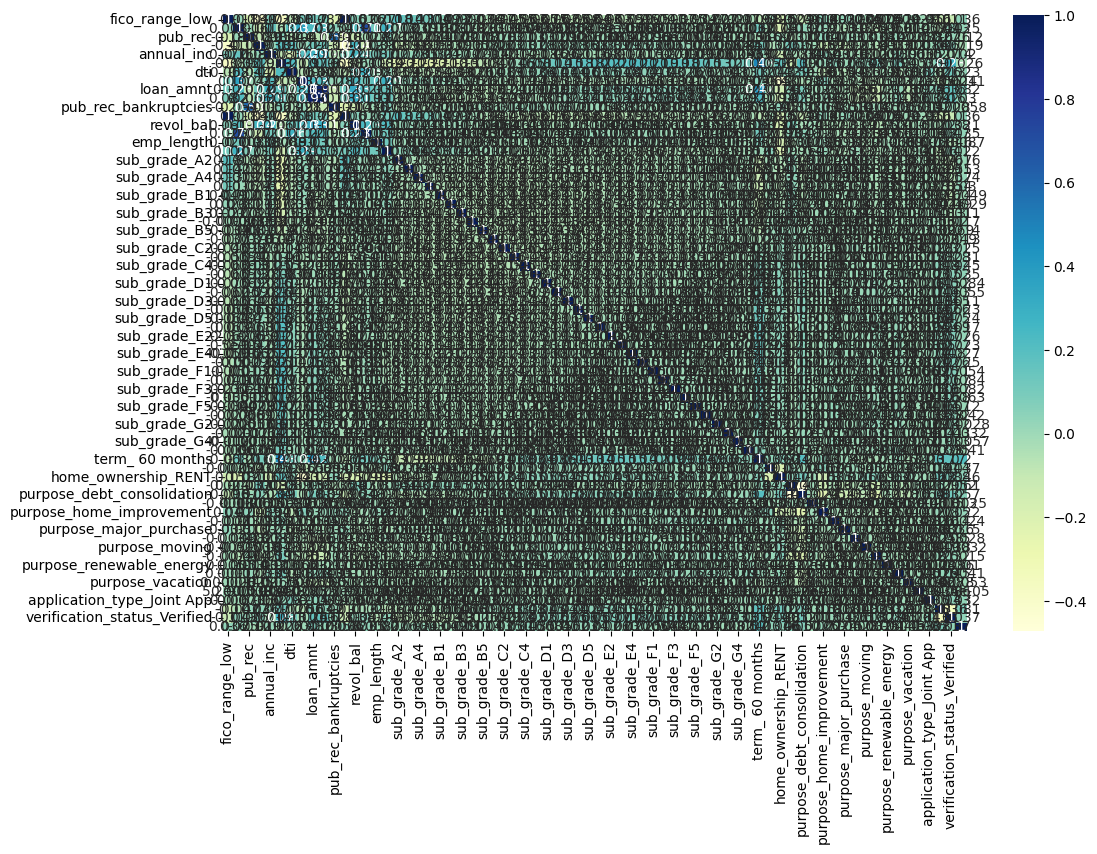

In [29]:
# correlation between features
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), annot = True, cmap = 'YlGnBu')

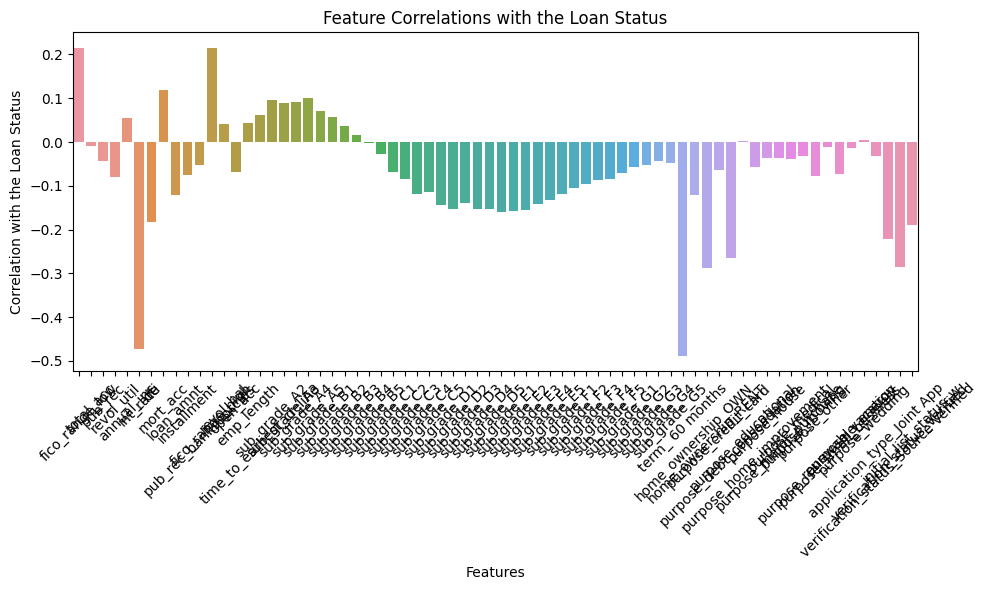

In [30]:
# Directly add y_train as a new column in X_train
# Make sure the name of the new column does not conflict with existing column names
df=X_train
df['loan_status'] = y_train

correlations = df.corr()['loan_status'].drop('loan_status')

plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index, y=correlations.values)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Correlation with the Loan Status')
plt.title('Feature Correlations with the Loan Status')
plt.tight_layout()
plt.show()

To find k-best PCAs, we perform the following steps:

- Standardize the d-dimensional dataset (feature scaling)
- Construct the covariance matrix
- Decompose the covariance matrix into its eigenvectors and eigenvalues
- Sort the eigenvalues by decreasing order and choose the top k eigenvectors
- Construct a projection matrix W of those selected k eigenvectors
- Transform dataset X using the projection matrix W onto the principal components to obtain new k-dimensional feature subspace, by calculating the dot product

In [31]:


print(f"X_train numeric shape: {X_train_numeric.shape}")
cov_mat = np.cov(X_train_numeric.T)
print(f"Covariance matrix shape: {cov_mat.shape}")

# Calculate eigenvalues and eigenvectors
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print(f"Eigenvalues:\n {eigen_vals}")
print(f"Eigenvalues shape: {eigen_vals.shape}")


X_train numeric shape: (393918, 70)
Covariance matrix shape: (70, 70)
Eigenvalues:
 [5.82942410e+10 6.01592138e+09 4.39605082e+08 6.06458451e+07
 5.73630635e+03 1.57637607e+03 3.63748227e+02 1.34164951e+02
 6.36356112e+01 1.51623948e+01 1.54002574e+01 1.20892477e+01
 2.55813296e+00 4.61891469e-01 3.24252325e-01 2.92349552e-01
 2.32319567e-01 1.96654834e-01 1.40648277e-01 1.15098242e-01
 9.74244081e-02 8.01516373e-02 7.89717663e-02 7.44895952e-02
 7.33809294e-02 7.21017920e-02 7.00836645e-02 6.82870752e-02
 6.55055036e-02 6.35205175e-02 6.25503025e-02 5.97937926e-02
 5.77567097e-02 5.40152254e-02 5.21896957e-02 4.98434198e-02
 4.77072342e-02 4.63417492e-02 4.38965087e-02 4.29951965e-02
 4.09054366e-02 3.93764257e-02 3.63009732e-02 3.30360241e-02
 2.88379210e-02 2.58665868e-02 2.27965786e-02 2.19438408e-02
 2.15267042e-02 1.79659199e-02 1.65147233e-02 1.45255049e-02
 1.32807370e-02 1.18128207e-02 5.00700326e-05 1.77597215e-05
 2.53788254e-06 8.45576178e-04 1.80754369e-03 9.83409734e-03
 

In [32]:
def variance_explained(eigenvalues):
  '''
    Plot how many PCA needed to explain most variance
    from the original feature space of our dataset
  '''
  var_exp = []
  total = sum(eigenvalues)
  for i in sorted(eigenvalues, reverse=True):
    var_ = i / total
    var_exp.append(var_)
  cum_var_exp = np.cumsum(var_exp)
  plt.bar(range(1, len(eigenvalues)+1), var_exp, alpha=0.5, align='center', label='Individual explained variance ratio')
  plt.step(range(1, len(eigenvalues)+1), cum_var_exp, where='mid', label='Cummulative explained ratio')
  plt.ylabel('Explained variance ratio')
  plt.xlabel('Principal component index')
  plt.legend(loc='best')
  plt.tight_layout()
  plt.show()

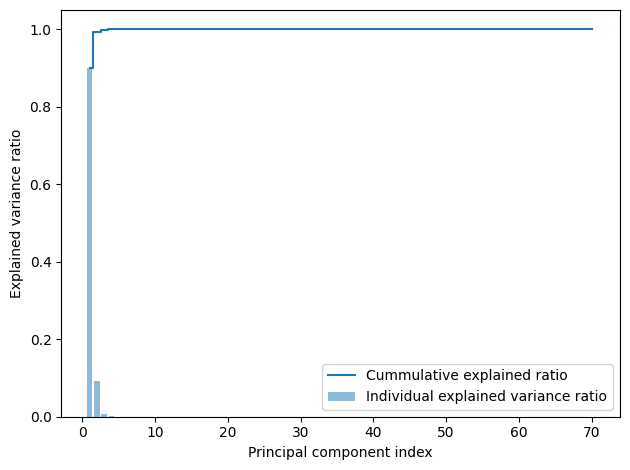

In [33]:
variance_explained(eigen_vals)

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Assuming 'loan_status' is the target variable and should not be part of the features
X_train = X_train.drop(columns=['loan_status'], errors='ignore')
X_validation = X_validation.drop(columns=['loan_status'], errors='ignore')
# Standardize features
scaler = StandardScaler()

# PCA transformation
pca = PCA(n_components=15)  # Adjust n_components based on your earlier analysis

# Define models
logistic_model = LogisticRegression(max_iter=1000)
knn_model = KNeighborsClassifier(n_neighbors=5)
lda_model = LinearDiscriminantAnalysis()
dt_model = DecisionTreeClassifier()

# List of models
models = [logistic_model, knn_model, lda_model, dt_model]
model_names = ['Logistic Regression', 'KNN', 'LDA', 'Decision Tree']

# Apply PCA and train models
for model, name in zip(models, model_names):
    # Create a pipeline with PCA and the current model
    pipeline = Pipeline([('scaler', scaler), ('pca', pca), (name, model)])
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = pipeline.predict(X_validation)
    
    # Evaluate the model
    print(f"Classification Report for {name}:")
    print(classification_report(y_validation, y_pred))
    print("-------------------------------------------------------")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.80      0.87      0.83     40277
         1.0       0.85      0.78      0.81     39994

    accuracy                           0.82     80271
   macro avg       0.82      0.82      0.82     80271
weighted avg       0.82      0.82      0.82     80271

-------------------------------------------------------
Classification Report for KNN:
              precision    recall  f1-score   support

         0.0       0.90      0.81      0.85     40277
         1.0       0.83      0.91      0.87     39994

    accuracy                           0.86     80271
   macro avg       0.86      0.86      0.86     80271
weighted avg       0.86      0.86      0.86     80271

-------------------------------------------------------
Classification Report for LDA:
              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83     40277
         1.0    

### Effects 
- Accuracy for Logistic Regression and KNN has increased while for LDA it has decreased. Accuracy for DT is almost the same

### Manual Feature Engineering

In [35]:
def feature_engineering(df):
    # Creating a new feature 'debt_to_income_ratio'
    df['debt_to_income_ratio'] = df['loan_amnt'] / df['annual_inc']

    # Binning FICO scores into categories
    df['fico_range'] = pd.cut(df['fico_range_low'], bins=[300, 579, 669, 739, 799, 850], labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'])

    # One-hot encoding the binned FICO scores
    df = pd.get_dummies(df, columns=['fico_range'], drop_first=True)
    
    # Drop original features used for new feature creation to avoid multicollinearity
    df = df.drop(['loan_amnt', 'annual_inc', 'fico_range_low'], axis=1)
    
    return df

# Function to replace inf/-inf with NaN
def replace_inf(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df


### Model Pipelines
- A model pipeline can be created to smooth out the preprocessing workflow
- https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/


In [36]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

# Transforming function for manual feature engineering
feature_eng_transformer = FunctionTransformer(feature_engineering)

# Add a step in your pipelines to handle inf/-inf
replace_inf_transformer = FunctionTransformer(replace_inf)

# Impute missing values that were originally inf/-inf
imputer = SimpleImputer(strategy='median')

# Scale features
scaler = StandardScaler()

# Logistic Regression Pipeline
logistic_pipeline = Pipeline([
    ('feature_eng', feature_eng_transformer),
    ('replace_inf', replace_inf_transformer),
    ('impute', imputer),
    ('scale', scaler),
    ('logistic', LogisticRegression(max_iter=1000))])

# KNN Pipeline
knn_pipeline = Pipeline([
    ('feature_eng', feature_eng_transformer),
    ('replace_inf', replace_inf_transformer),
    ('impute', imputer),
    ('scale', scaler),
    ('knn', KNeighborsClassifier())
])

# LDA Pipeline
lda_pipeline = Pipeline([
    ('feature_eng', feature_eng_transformer),
    ('replace_inf', replace_inf_transformer),
    ('impute', imputer),
    ('scale', scaler),
    ('lda', LinearDiscriminantAnalysis())
])

# Decision Tree Pipeline
dt_pipeline = Pipeline([
    ('feature_eng', feature_eng_transformer),
    ('replace_inf', replace_inf_transformer),
    ('impute', imputer),
    ('scale', scaler),
    ('dt', DecisionTreeClassifier())
])

# Example of fitting the Logistic Regression Pipeline
logistic_pipeline.fit(X_train, y_train)
knn_pipeline.fit(X_train, y_train)
lda_pipeline.fit(X_train, y_train)
dt_pipeline.fit(X_train, y_train)

# Make predictions (as an example with the logistic regression model)
y_pred_logistic = logistic_pipeline.predict(X_validation)
y_pred_KNN = knn_pipeline.predict(X_validation)
y_pred_lda = lda_pipeline.predict(X_validation)
y_pred_dt = dt_pipeline.predict(X_validation)


# Evaluate the Logistic Regression model
accuracy_logistic = accuracy_score(y_validation, y_pred_logistic)
print(f'Logistic Regression Accuracy: {accuracy_logistic}')

# Evaluate the KNN model
accuracy_knn = accuracy_score(y_validation, y_pred_KNN)
print(f'KNN Accuracy: {accuracy_knn}')

# Evaluate the LDA model
accuracy_lda = accuracy_score(y_validation, y_pred_lda)
print(f'LDA Accuracy: {accuracy_lda}')

# Evaluate the Decision Tree model
accuracy_dt = accuracy_score(y_validation, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt}')


Logistic Regression Accuracy: 0.9106651218995653
KNN Accuracy: 0.875758368526616
LDA Accuracy: 0.8983069850880143
Decision Tree Accuracy: 0.8029425321722664


Applying Manual Feature Engineering 
- Creating new Feature : 'debt_to_income_ratio'
- Binning FICO scores into categories and then One-hot Encoding

Effect 
- Accuracy for LR and KNN has Increased. FOR LDA and DT it has pretty much remain the same.


# Hyperparameter Tuning Of Logistics Regression and LDA

- Keep the transformed data from pipeline and do Hyper-parameter tuning on lr and LDA

In [37]:
from sklearn.model_selection import GridSearchCV

# Define the pipeline without the final estimator
preprocessing_pipeline = Pipeline([
    ('feature_eng', feature_eng_transformer),
    ('replace_inf', replace_inf_transformer),
    ('impute', imputer),
    ('scale', scaler)
])

# Transform the data using the defined preprocessing pipeline
X_train_transformed = preprocessing_pipeline.fit_transform(X_train)
X_validation_transformed = preprocessing_pipeline.transform(X_validation)

param_grid_lr = {
    'C': [0.01, 0.1],  # Reduced range for faster processing and stronger regularization
    'penalty': ['l2'],  # Using only 'l2' for simplicity
}

# Increase max_iter to help with convergence
logistic_model = LogisticRegression(max_iter=5000)

# Use n_jobs=-1 to utilize all CPU cores
grid_search_lr = GridSearchCV(logistic_model, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the transformed data
grid_search_lr.fit(X_train_transformed, y_train)

# Print the best parameters and the best score
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best score for Logistic Regression:", grid_search_lr.best_score_)

# Predict and evaluate
y_pred_lr = grid_search_lr.predict(X_validation_transformed)
accuracy_lr = accuracy_score(y_validation, y_pred_lr)
print(f'Logistic Regression Accuracy with Best Parameters: {accuracy_lr}')


# Preprocess the test data using the same preprocessing pipeline
X_test_transformed = preprocessing_pipeline.transform(X_test_smaller)

# Use the best estimator from the grid search to make predictions on the preprocessed test data
y_pred_test = grid_search_lr.best_estimator_.predict(X_test_transformed)

# Evaluate the model performance on the test data
accuracy_test = accuracy_score(y_test_smaller, y_pred_test)
print(f'Logistic Regression Accuracy on Test Data: {accuracy_test}')


Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2'}
Best score for Logistic Regression: 0.8695900279542446
Logistic Regression Accuracy with Best Parameters: 0.915311881003102
Logistic Regression Accuracy on Test Data: 0.9150128938221773


In [1]:

# Define the parameter grid for LDA
param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],  # Different solver options
    'shrinkage': [None, 'auto', 0.01, 0.1, 0.5, 0.9]  # Shrinkage parameter for lsqr and eigen solvers
}

# Initialize the LDA model
lda_model = LinearDiscriminantAnalysis()

# Initialize the GridSearchCV object with LDA model and parameter grid
grid_search_lda = GridSearchCV(lda_model, param_grid_lda, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the transformed training data
grid_search_lda.fit(X_train_transformed, y_train)

# Print the best parameters and the best score obtained during the grid search
print("Best parameters for LDA:", grid_search_lda.best_params_)
print("Best score for LDA:", grid_search_lda.best_score_)

# Predict and evaluate on the validation set
y_pred_lda = grid_search_lda.predict(X_validation_transformed)
accuracy_lda = accuracy_score(y_validation, y_pred_lda)
print(f'LDA Accuracy with Best Parameters: {accuracy_lda}')

# Predict and evaluate on the test set
y_pred_test_lda = grid_search_lda.predict(X_test_transformed)
accuracy_test_lda = accuracy_score(y_test_smaller, y_pred_test_lda)
print(f'LDA Accuracy on Test Data: {accuracy_test_lda}')

print("LDA Classification Report on Final Test Set:")
print(classification_report(y_test, y_pred_test_lda))  


NameError: name 'LinearDiscriminantAnalysis' is not defined